# EuroSAT_MS – Colab + Google Drive Version (Conventional ML Baseline)

This notebook is an updated solution that:
- Mounts **Google Drive** and extracts your **EuroSAT_MS .zip** directly in Colab.
- Covers the **visual tasks** (RGB view, NDVI, thresholded segmentation mask, per-band inspection).
- For the **first modeling task**, uses **conventional machine learning** (feature engineering + scikit-learn classifiers) — **not** a CNN.
- Compares simple models (Logistic Regression, SVM, RandomForest) on a validation split.


## 1) Mount Google Drive and extract the dataset


In [4]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.7 MB/s eta 0:00:00


In [26]:
from google.colab import drive
from pathlib import Path
import os, glob, subprocess
import os, sys, random, math, json, glob
import numpy as np
import numpy as np
import rasterio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [6]:
drive.mount('/content/drive')

ZIP_PATH = "/content/drive/MyDrive/ML_HSG/EuroSAT_MS.zip"
DATA_ROOT = Path("/content/EuroSAT_MS")

if not DATA_ROOT.exists():
    print("Extracting dataset from", ZIP_PATH, "to /content ...")
    !unzip -q -o "$ZIP_PATH" -d "/content"
else:
    print("Dataset already extracted at", DATA_ROOT)

print("DATA_ROOT =", DATA_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Auto-detected zip: /content/drive/MyDrive/ML_HSG/EuroSAT_MS.zip
Extracting... this may take a minute.
Using data root: /content/EuroSAT_MS


## 2) Configuration & Utilities


In [8]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Data root:", DATA_ROOT.resolve())


Data root: /content/EuroSAT_MS


## 3) Load GeoTIFFs and Visualize (RGB, NDVI, Bands)


In [ ]:
def read_multiband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()  # (C,H,W)
        arr = arr.astype(np.float32)
        # robust per-band normalization to [0,1]
        C,H,W = arr.shape
        for i in range(C):
            band = arr[i]
            lo, hi = np.percentile(band, [2, 98])
            if hi > lo:
                band = (band - lo) / (hi - lo)
            else:
                bmin, bmax = band.min(), band.max()
                band = (band - bmin) / (bmax - bmin + 1e-6)
            arr[i] = np.clip(band, 0.0, 1.0)
        return arr

In [ ]:
def ndvi_from_arr(arr):
    nir = arr[7]  # B8
    red = arr[3]  # B4
    return (nir - red) / (nir + red + 1e-6)

In [ ]:
def show_sample(path, title="Sample"):
    arr = read_multiband_tif(path)
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1)  # B4,B3,B2
    ndvi = ndvi_from_arr(arr)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(np.clip(rgb,0,1)); plt.title(f"{title} – RGB"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.show()

Detected classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Found 27000 images.


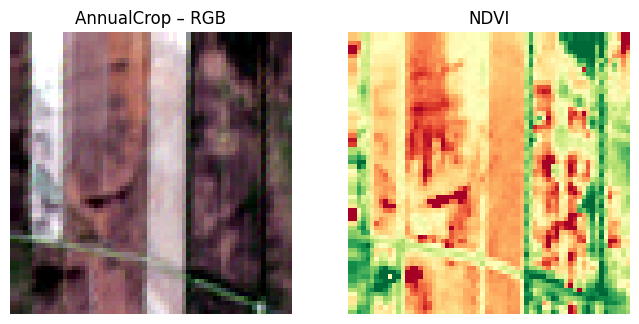

In [10]:
# Expected Sentinel-2 band order (EuroSAT-MS): indices 0..12 for 13 bands
# NDVI: NIR=B8 (idx 7), RED=B4 (idx 3)

CLASS_NAMES = []
if DATA_ROOT.exists():
    for d in sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()]):
        CLASS_NAMES.append(d.name)
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
print("Detected classes:", CLASS_NAMES)

# Collect samples
samples = []
for cls in CLASS_NAMES:
    for tif in (DATA_ROOT/cls).glob("*.tif"):
        samples.append((tif, CLASS_TO_IDX[cls]))
print(f"Found {len(samples)} images.")

# Quick peek (1 sample)
import matplotlib.pyplot as plt

if samples:
    show_sample(samples[0][0], title=CLASS_NAMES[samples[0][1]])


### NDVI thresholding (vegetation mask)


In [ ]:
def threshold_ndvi(ndvi, thr=0.3):
    return (ndvi > thr).astype(np.uint8)

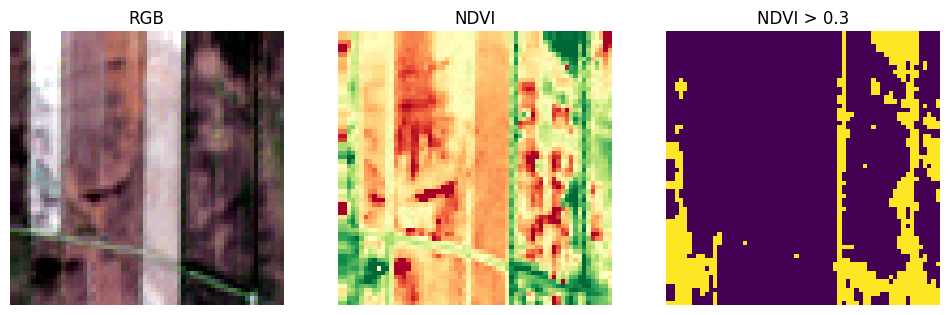

In [11]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    ndvi = ndvi_from_arr(arr)
    mask = threshold_ndvi(ndvi, thr=0.3)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(np.stack([arr[3],arr[2],arr[1]], axis=-1)); plt.title("RGB"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask, interpolation="nearest"); plt.title("NDVI > 0.3"); plt.axis("off")
    plt.show()


### Per-band inspection


In [12]:
def show_bands(arr):
    import math
    cols = 4
    rows = math.ceil(arr.shape[0]/cols)
    plt.figure(figsize=(12, 3*rows))
    for i in range(arr.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(arr[i])
        plt.title(f"Band {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

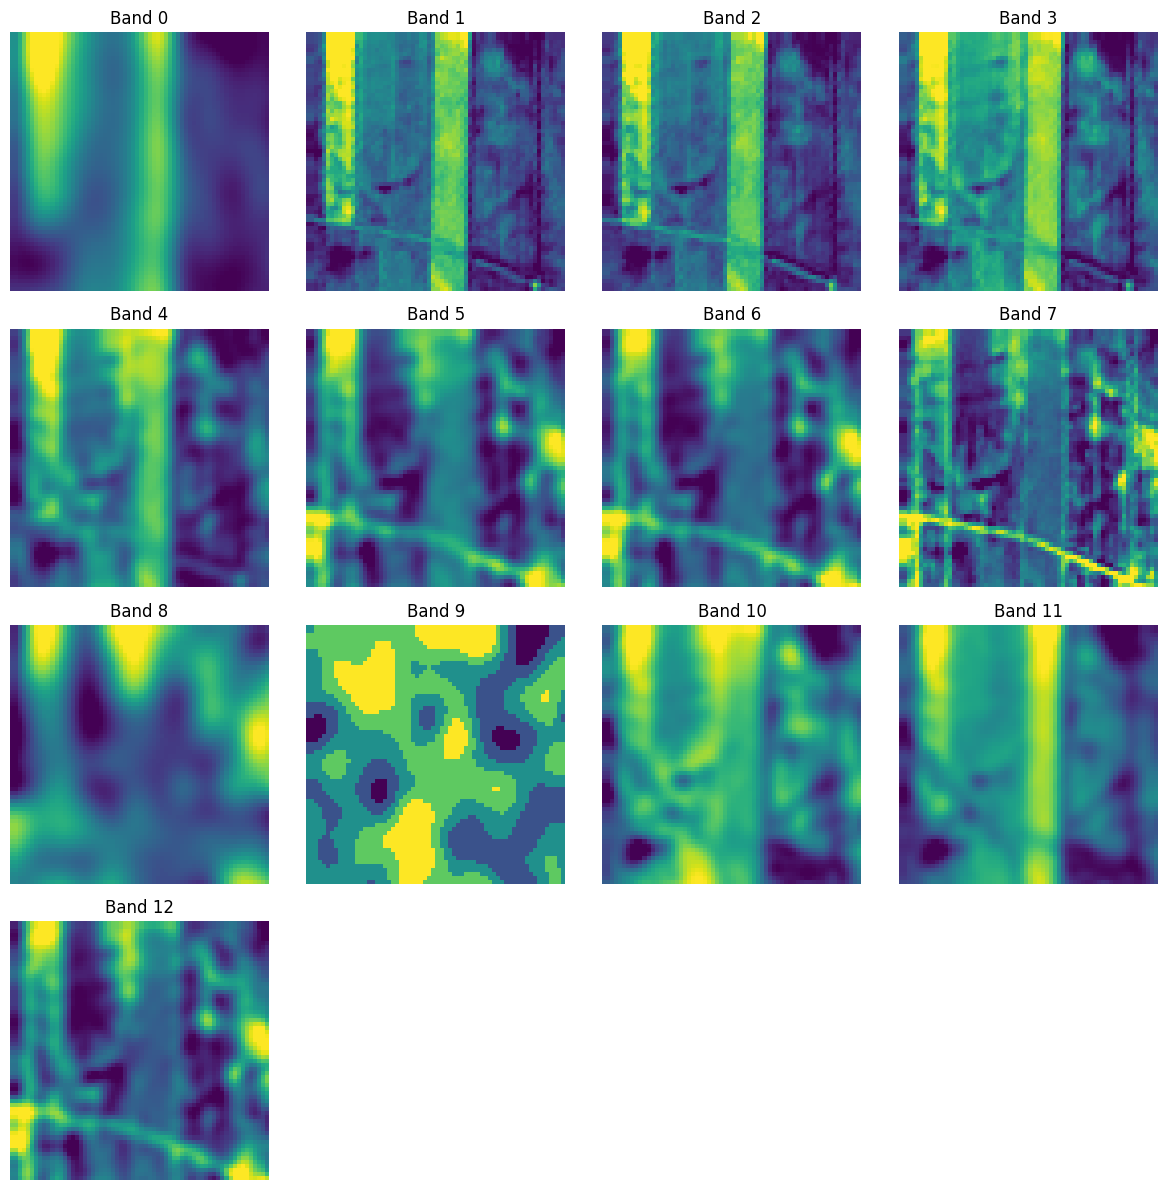

In [13]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    show_bands(arr)


## 4) Feature Engineering for Conventional ML


In [15]:
def image_features(arr):
    """Return a 1D feature vector using simple, fast statistics per band + NDVI."""
    feats = []
    # per-band stats
    for i in range(arr.shape[0]):
        band = arr[i]
        p25, p50, p75 = np.percentile(band, [25,50,75])
        feats.extend([band.mean(), band.std(), p25, p50, p75])
    # NDVI stats
    ndvi = ndvi_from_arr(arr)
    p25, p50, p75 = np.percentile(ndvi, [25,50,75])
    veg_ratio = (ndvi > 0.3).mean()
    feats.extend([ndvi.mean(), ndvi.std(), p25, p50, p75, veg_ratio])
    return np.array(feats, dtype=np.float32)

In [17]:
# compact spatial features via downsampling then PCA later
def downsampled_flat(arr, target=16):
    # simple spatial downsample by stride to roughly target x target per band
    C,H,W = arr.shape
    sx = max(1, H//target)
    sy = max(1, W//target)
    small = arr[:, ::sx, ::sy]
    return small.reshape(-1)  # C * h * w

In [18]:
# Build dataset matrices
X_stats, y, paths = [], [], []
X_flat = []
for p, lab in samples:
    a = read_multiband_tif(p)
    X_stats.append(image_features(a))
    X_flat.append(downsampled_flat(a, target=16))
    y.append(lab); paths.append(str(p))

X_stats = np.stack(X_stats) if X_stats else np.empty((0,))
X_flat  = np.stack(X_flat)  if X_flat  else np.empty((0,))
y = np.array(y)
print("Feature shapes -> stats:", X_stats.shape, "| flat (for PCA):", X_flat.shape, "| labels:", y.shape)


Feature shapes -> stats: (27000, 71) | flat (for PCA): (27000, 3328) | labels: (27000,)


## 5) Train/Validation/Test Split


In [23]:
N = len(y)
idx = np.arange(N)

# 1) Train/Test (stratified)
idx_tr, idx_te = train_test_split(
    idx, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)

# 2) Train/Val (stratified) — only within the training set
y_tr = y[idx_tr]
idx_tr_sub, idx_val_sub = train_test_split(
    idx_tr, test_size=0.20, random_state=RANDOM_SEED, stratify=y_tr
)

# Now slice ALL views (stats, flat, labels, paths) with the SAME indices
Xtr_stats, Xval_stats, Xte_stats = X_stats[idx_tr_sub], X_stats[idx_val_sub], X_stats[idx_te]
Xtr_flat,  Xval_flat,  Xte_flat  = X_flat[idx_tr_sub],  X_flat[idx_val_sub],  X_flat[idx_te]
ytr,       yval,       yte       = y[idx_tr_sub],       y[idx_val_sub],       y[idx_te]

paths_tr = [paths[i] for i in idx_tr_sub]
paths_val = [paths[i] for i in idx_val_sub]
paths_te  = [paths[i] for i in idx_te]

print("Stats features -> train/val/test:", Xtr_stats.shape, Xval_stats.shape, Xte_stats.shape)
print("Flat  features -> train/val/test:", Xtr_flat.shape,  Xval_flat.shape,  Xte_flat.shape)
print("Labels ->", ytr.shape, yval.shape, yte.shape)


Stats features -> train/val/test: (17280, 71) (4320, 71) (5400, 71)
Flat  features -> train/val/test: (17280, 3328) (4320, 3328) (5400, 3328)
Labels -> (17280,) (4320,) (5400,)


## 6) Conventional ML Baselines (scikit-learn)


In [ ]:
def eval_pipeline(name, pipe, Xtr, ytr, Xval, yval):
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xval)
    acc = accuracy_score(yval, pred)
    print(f"[{name}] val acc: {acc:.3f}")
    return acc, pipe

In [ ]:
# Model A: Stats features -> Standardize -> Classifier
pipelines_stats = {
    "LogReg": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced"))]),
    "SVM-RBF": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))]),
    "RandomForest": Pipeline([("clf", RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample"))]),
}

In [ ]:
# Model B: Flattened downsampled -> Standardize -> PCA -> Classifier
pipelines_flat = {
    "PCA+LogReg": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]),
    "PCA+SVM": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))]),
}

In [24]:
best = (0.0, None, None)
print("=== Using Stats Features ===")
for name, pipe in pipelines_stats.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_stats, ytr, Xval_stats, yval)
    if acc > best[0]:
        best = (acc, f"stats::{name}", fitted)

print("\n=== Using Downsampled + PCA Features ===")
for name, pipe in pipelines_flat.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_flat, ytr, Xval_flat, yval)
    if acc > best[0]:
        best = (acc, f"pca::{name}", fitted)

print("\nBest model on validation:", best[1], "with acc", round(best[0],3))
best_model = best[2]


=== Using Stats Features ===
[LogReg] val acc: 0.711
[SVM-RBF] val acc: 0.810
[RandomForest] val acc: 0.735

=== Using Downsampled + PCA Features ===
[PCA+LogReg] val acc: 0.480
[PCA+SVM] val acc: 0.710

Best model on validation: stats::SVM-RBF with acc 0.81


## 7) Test Evaluation


                      precision    recall  f1-score   support

          AnnualCrop       0.83      0.84      0.84       600
              Forest       0.87      0.91      0.89       600
HerbaceousVegetation       0.67      0.72      0.70       600
             Highway       0.73      0.64      0.68       500
          Industrial       0.88      0.87      0.88       500
             Pasture       0.79      0.77      0.78       400
       PermanentCrop       0.65      0.62      0.64       500
         Residential       0.84      0.87      0.85       600
               River       0.93      0.92      0.93       500
             SeaLake       0.90      0.90      0.90       600

            accuracy                           0.81      5400
           macro avg       0.81      0.81      0.81      5400
        weighted avg       0.81      0.81      0.81      5400



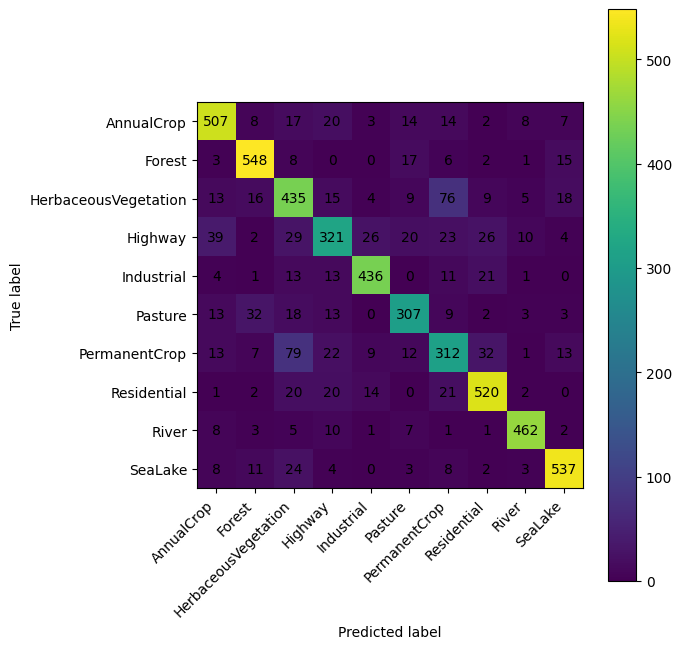

In [27]:
# Choose the right test features for the winning pipeline
if best_model is None:
    raise RuntimeError("No model trained. Check earlier cells.")

use_stats = best[1].startswith("stats::")
Xte = Xte_stats if use_stats else Xte_flat

yhat = best_model.predict(Xte)
print(classification_report(yte, yhat, target_names=CLASS_NAMES))

cm = confusion_matrix(yte, yhat)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(CLASS_NAMES)), yticks=np.arange(len(CLASS_NAMES)),
       xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
       ylabel="True label", xlabel="Predicted label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], "d"), ha="center", va="center")
plt.tight_layout()
plt.show()


## 8) Notes on Distribution Shift (still relevant)

- Ensure your splits avoid **tile leakage** (images from the same large scene should not be in both train and test).
- Normalize per band using **training-set** statistics only.
- Use augmentations that simulate realistic remote-sensing variability.
- Consider domain adaptation or self-supervised pretraining if the target domain differs significantly.
